## ARTIFICIAL INTELLIGENCE ON LEGAL LANGUAGE PROCESSING: USING DEEP LEARNING TO FOUND THE REGULATORY LAW FRAMEWORK FOR THE THIRD SECTOR

### Mauricio Barros de Jesus - mauriciobajesus@gmail.com 
### McCormick & Ryan (2019) inspired the source code.  Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from - https://mccormickml.com/2019/07/22/BERT-fine-tuning/


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Oct 22 18:45:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0    70W / 400W |      0MiB / 81920MiB |      2%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [2]:
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from tqdm import tqdm
import re
import unicodedata
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from pathlib import Path
from sklearn.utils import resample, shuffle
import random

import seaborn as sns

from sklearn.metrics import mean_absolute_error, matthews_corrcoef, auc, roc_curve
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, accuracy_score, f1_score, recall_score 

import time
import datetime

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
## Load BERT tokenizer. We choose BERTimbau Base https://huggingface.co/neuralmind/bert-base-portuguese-cased
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [6]:
BASE_DIR = Path(os.path.abspath('')).resolve()
batch_size = 16
max_length_bert = 512

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

In [7]:
BASE_DIR

PosixPath('/home/mauricio.jesus/regbr')

In [8]:
df_train = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset','train_test_val','df_train_12092022_v2.xlsx')))
df_test = pd.read_excel(Path(os.path.join(BASE_DIR, 'dataset','train_test_val','df_test_12092022_v2.xlsx')))


In [9]:
df_test = shuffle(df_test)
df_train = shuffle(df_train)


In [10]:
df_train = df_train[df_train["cat"].isin([0,1])]

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6473 entries, 6091 to 3960
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6473 non-null   int64 
 1   cat     6473 non-null   int64 
 2   text    6473 non-null   object
 3   versao  6473 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 252.9+ KB


In [12]:
df_train.cat.value_counts()

0    6025
1     448
Name: cat, dtype: int64

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 136 to 242
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      272 non-null    int64 
 1   cat     272 non-null    int64 
 2   text    272 non-null    object
 3   versao  272 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 10.6+ KB


In [14]:
df_test.cat.value_counts()

0    158
1    114
Name: cat, dtype: int64

In [15]:
# Get the lists of sentences and their labels.
sentences_train = df_train.text.values
labels_train = df_train.cat.values

# Get the lists of sentences and their labels.
sentences_val = df_test.text.values
labels_val = df_test.cat.values


In [16]:
### Ds Labels
labelsMap = {"outros":0
          ,"terceiro_setor":1
          ,"nao_classificado":2
          }

In [17]:
def buildPyTochDataset(p_sentences,p_labels):
    """ Tokenize all of the sentences and map the tokens to thier word IDs. """
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in p_sentences:
        encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_length_bert,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(p_labels)

    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [18]:
train_dataset = buildPyTochDataset(sentences_train,labels_train)
val_dataset = buildPyTochDataset(sentences_val,labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/mauricio.jesus/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

6,473 training samples
  272 validation samples


In [20]:
# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size # Evaluate with this batch size.
        )

In [21]:
# Load BertForSequenceClassification. We choose BERTimbau Base https://huggingface.co/neuralmind/bert-base-portuguese-cased
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', 
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTr

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
optimizer = Adam(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
### Plot 
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)


### Function to calculate a lot of metrics
def calcMetrics(preds, labels,plot=False):

    y_pred = np.concatenate(preds, axis=0)
    y_pred = np.argmax(y_pred, axis=1).flatten()
    y_test = np.concatenate(labels, axis=0)

    metrica = dict()
    metrica['mae'] = mean_absolute_error(y_test, y_pred)
    metrica['mdae'] = median_absolute_error(y_test, y_pred)
    metrica['mse'] = mean_squared_error(y_test, y_pred)
    metrica['mape'] = mean_absolute_percentage_error(y_test, y_pred)
    metrica['mdape'] = ((pd.Series(y_test) - pd.Series(y_pred))/ pd.Series(y_test)).abs().median()
    metrica['r_squared'] = r2_score(y_test, y_pred)
    metrica['accuracy_score'] = accuracy_score(y_test, y_pred)
    metrica['f1_score'] = f1_score(y_test, y_pred)
    metrica['f1_score_macro'] = f1_score(y_test, y_pred, average='macro')
    metrica['f1_score_micro'] = f1_score(y_test, y_pred, average='micro')
    metrica['f1_score_weighted'] = f1_score(y_test, y_pred, average='weighted')
    metrica['recall_score'] = recall_score(y_test, y_pred)
    metrica['matthews_corrcoef'] = matthews_corrcoef(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    metrica['auc'] = auc(fpr, tpr)
    if(plot):
        plot_roc_curve(fpr, tpr)

    return metrica




In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 80

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(device)

all_metrics = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    logists_training, label_ids_training = [], []

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.flat_accuracy
        total_train_loss += loss.item()


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        logists_training.append(logits)
        label_ids_training.append(label_ids)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(calcMetrics(logists_training, label_ids_training))
    all_metrics.append({  'epoch': epoch_i + 1
                               , 'type': 'training'
                               , 'logists':logists_training
                               , 'labels': label_ids_training
                               })
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
        
    ### Save model
    PATH = os.path.join(BASE_DIR,'models',f'model_state.save_{epoch_i}')
    torch.save({
                'epoch': epoch_i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                #'avg_train_loss': avg_train_loss,
                }, PATH)
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    logists_test, label_ids_tests = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        
            loss = outputs.loss
            logits = outputs.logits

            
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            logists_test.append(logits)
            label_ids_tests.append(label_ids)
    
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    valid_metrics = calcMetrics(logists_test, label_ids_tests)


    all_metrics.append({  'epoch': epoch_i + 1
                               , 'type': 'aval'
                               , 'logists':logists_test
                               , 'labels': label_ids_tests
                               })

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1-Score': valid_metrics['f1_score'],
            'Valid. F1-Score-Macro': valid_metrics['f1_score_macro'],
            'Valid. F1-Score-Micro': valid_metrics['f1_score_micro'],
            'Valid. F1-Score-Weighted': valid_metrics['f1_score_weighted'],
            'Valid. AUC': valid_metrics["auc"],
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

cuda

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:05.
  Batch    80  of    405.    Elapsed: 0:00:10.
  Batch   120  of    405.    Elapsed: 0:00:15.
  Batch   160  of    405.    Elapsed: 0:00:20.
  Batch   200  of    405.    Elapsed: 0:00:25.
  Batch   240  of    405.    Elapsed: 0:00:30.
  Batch   280  of    405.    Elapsed: 0:00:34.
  Batch   320  of    405.    Elapsed: 0:00:39.
  Batch   360  of    405.    Elapsed: 0:00:44.
  Batch   400  of    405.    Elapsed: 0:00:49.
{'mae': 0.020083423451259075, 'mdae': 0.0, 'mse': 0.020083423451259075, 'mape': 17393788148348.91, 'mdape': 0.0, 'r_squared': 0.6882446650859514, 'accuracy_score': 0.9799165765487409, 'f1_score': 0.840686274509804, 'f1_score_macro': 0.91498452225078, 'f1_score_micro': 0.9799165765487409, 'f1_score_weighted': 0.9789983222896219, 'recall_score': 0.765625, 'matthews_corrcoef': 0.8346546047379232, 'auc': 0.8807378112033195}

  Average training loss: 0.08
  Training epcoh took: 0:00

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(



Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.29
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:05.
  Batch    80  of    405.    Elapsed: 0:00:10.
  Batch   120  of    405.    Elapsed: 0:00:14.
  Batch   160  of    405.    Elapsed: 0:00:19.
  Batch   200  of    405.    Elapsed: 0:00:24.
  Batch   240  of    405.    Elapsed: 0:00:29.
  Batch   280  of    405.    Elapsed: 0:00:34.
  Batch   320  of    405.    Elapsed: 0:00:38.
  Batch   360  of    405.    Elapsed: 0:00:43.
  Batch   400  of    405.    Elapsed: 0:00:48.
{'mae': 0.004325660435655801, 'mdae': 0.0, 'mse': 0.004325660435655801, 'mape': 6261763733405.6045, 'mdape': 0.0, 'r_squared': 0.9328526970954357, 'accuracy_score': 0.9956743395643441, 'f1_score': 0.9683972911963883, 'f1_score_macro': 0.9830377832433019, 'f1_score_micro': 0.9956743395643441, 'f1_score_weighted': 0.9956517217796277, 'recall_score': 0.9575892857142857, 'matthews_corrcoef': 0.966

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(



Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.22
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:05.
  Batch    80  of    405.    Elapsed: 0:00:10.
  Batch   120  of    405.    Elapsed: 0:00:14.
  Batch   160  of    405.    Elapsed: 0:00:19.
  Batch   200  of    405.    Elapsed: 0:00:24.
  Batch   240  of    405.    Elapsed: 0:00:29.
  Batch   280  of    405.    Elapsed: 0:00:34.
  Batch   320  of    405.    Elapsed: 0:00:38.
  Batch   360  of    405.    Elapsed: 0:00:43.
  Batch   400  of    405.    Elapsed: 0:00:48.
{'mae': 0.0023173180905298935, 'mdae': 0.0, 'mse': 0.0023173180905298935, 'mape': 2087254577801.8694, 'mdape': 0.0, 'r_squared': 0.9640282305868405, 'accuracy_score': 0.9976826819094701, 'f1_score': 0.9830890642615558, 'f1_score_macro': 0.9909225900128578, 'f1_score_micro': 0.9976826819094701, 'f1_score_weighted': 0.9976717902469084, 'recall_score': 0.9732142857142857, 'matthews_corrcoef': 0.9

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(



Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.18
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    405.    Elapsed: 0:00:05.
  Batch    80  of    405.    Elapsed: 0:00:10.
  Batch   120  of    405.    Elapsed: 0:00:14.
  Batch   160  of    405.    Elapsed: 0:00:19.
  Batch   200  of    405.    Elapsed: 0:00:24.
  Batch   240  of    405.    Elapsed: 0:00:29.
  Batch   280  of    405.    Elapsed: 0:00:34.
  Batch   320  of    405.    Elapsed: 0:00:38.
  Batch   360  of    405.    Elapsed: 0:00:43.
  Batch   400  of    405.    Elapsed: 0:00:48.
{'mae': 0.001390390854317936, 'mdae': 0.0, 'mse': 0.001390390854317936, 'mape': 0.001390390854317936, 'mdape': 0.0, 'r_squared': 0.9784169383521043, 'accuracy_score': 0.9986096091456821, 'f1_score': 0.9898534385569334, 'f1_score_macro': 0.9945535540077146, 'f1_score_micro': 0.9986096091456821, 'f1_score_weighted': 0.998603074148145, 'recall_score': 0.9799107142857143, 'matthews_corrcoef': 0.98

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(



Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.20
  Validation took: 0:00:01

Training complete!
Total training took 0:03:22 (h:mm:ss)


In [27]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Valid. F1-Score,Valid. F1-Score-Macro,Valid. F1-Score-Micro,Valid. F1-Score-Weighted,Valid. AUC,Training Time,Validation Time
epoch,,,,,,,,,
1,0.078676,0.294724,0.919431,0.934190,0.937500,0.936578,0.925439,0:00:49,0:00:01
2,0.021341,0.221946,0.949772,0.957963,0.959559,0.959288,0.952976,0:00:49,0:00:01
3,0.011516,0.175166,0.954545,0.961841,0.963235,0.963021,0.957362,0:00:49,0:00:01
4,0.007033,0.202643,0.944954,0.954072,0.955882,0.955547,0.948590,0:00:49,0:00:01


In [28]:
dfMetricas = pd.DataFrame()

for listMetrics in all_metrics:  
    logists = listMetrics["logists"]
    labels  = listMetrics["labels"]
    metrics = calcMetrics(logists, labels,False)
    metrics["epoch"] = listMetrics["epoch"]
    metrics["type"] = listMetrics["type"]
    dfMetricas = pd.concat([dfMetricas,pd.DataFrame([metrics])])

dfMetricas.to_excel(Path(os.path.join(BASE_DIR,'dataset','train_test_val','df_train_result_15092022_v1.xlsx')), index=False)
dfMetricas

,mae,mdae,mse,mape,mdape,r_squared,accuracy_score,f1_score,f1_score_macro,f1_score_micro,f1_score_weighted,recall_score,matthews_corrcoef,auc,epoch,type
0,0.020083,0.0,0.020083,1.739379e+13,0.0,0.688245,0.979917,0.840686,0.914985,0.979917,0.978998,0.765625,0.834655,0.880738,1,training
0,0.062500,0.0,0.062500,6.250000e-02,0.0,0.743282,0.937500,0.919431,0.934190,0.937500,0.936578,0.850877,0.876482,0.925439,1,aval
0,0.004326,0.0,0.004326,6.261764e+12,0.0,0.932853,0.995674,0.968397,0.983038,0.995674,0.995652,0.957589,0.966147,0.978048,2,training
0,0.040441,0.0,0.040441,1.655735e+13,0.0,0.833889,0.959559,0.949772,0.957963,0.959559,0.959288,0.912281,0.918191,0.952976,2,aval
0,0.002317,0.0,0.002317,2.087255e+12,0.0,0.964028,0.997683,0.983089,0.990923,0.997683,0.997672,0.973214,0.981904,0.986358,3,training
0,0.036765,0.0,0.036765,1.655735e+13,0.0,0.848990,0.963235,0.954545,0.961841,0.963235,0.963021,0.921053,0.925473,0.957362,3,aval
0,0.001390,0.0,0.001390,1.390391e-03,0.0,0.978417,0.998610,0.989853,0.994554,0.998610,0.998603,0.979911,0.989166,0.989955,4,training
0,0.044118,0.0,0.044118,1.655735e+13,0.0,0.818787,0.955882,0.944954,0.954072,0.955882,0.955547,0.903509,0.910939,0.948590,4,aval


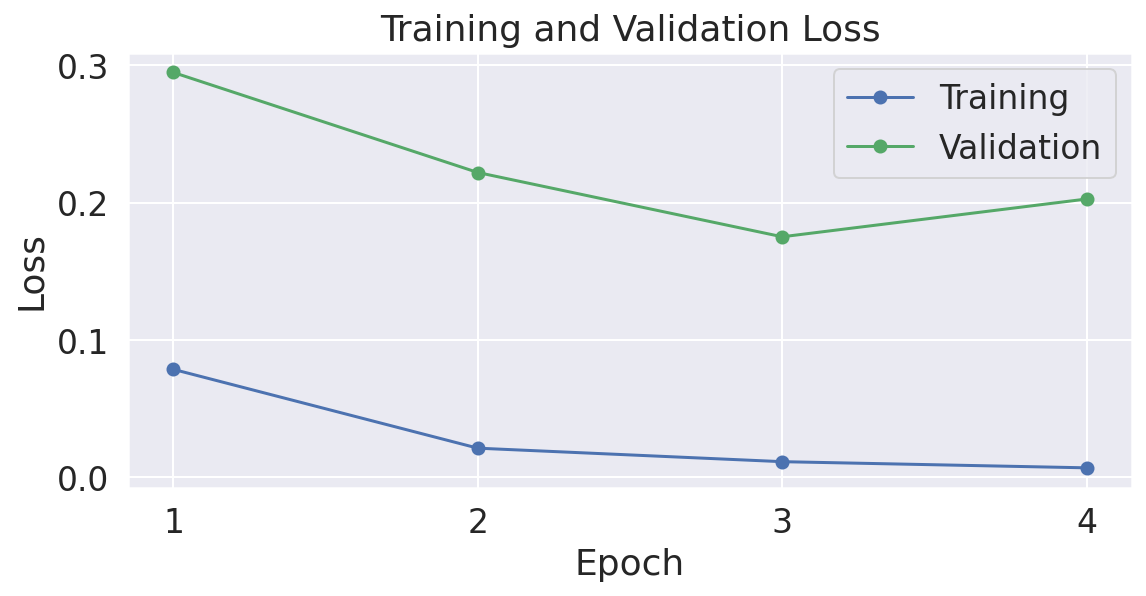

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (9,4)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.savefig(Path(os.path.join(BASE_DIR,'dataset','results','training_avlidation_loss.png')),bbox_inches='tight')
plt.show()